In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
EXTRA_SMALL_SIZE = 14
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

In [3]:
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=EXTRA_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=EXTRA_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
# https://data.humdata.org/dataset/c87c4508-9caf-4959-bf06-6ab4855d84c6
df = pd.read_csv('datasets/owid-covid-data.csv', usecols=['location', 'date', 'total_cases', 'total_tests','total_tests_per_thousand'])
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] >= np.datetime64('2021-01-01')]
df['positive_rate'] = df['total_cases'] / df['total_tests']
df = df[(df['location'] != 'International') & (df['location'] != 'World')]

In [5]:
df['location'].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

In [6]:
df_flights = pd.read_csv('datasets/edge_lists/edge_list_processed_all-Canada.txt', names=['date', 'From', 'To', 'number of flights'])
df_flights['date'] = pd.to_datetime(df_flights['date'])
df_flights

,date,From,To,number of flights
0,2021-01-02,Canada,Canada,172
1,2021-01-02,Afghanistan,Canada,14
2,2021-01-02,US,US,7
3,2021-01-02,Canada,South Korea,4
4,2021-01-02,Egypt,Canada,1
...,...,...,...,...
3719,2021-04-30,Canada,Qatar,1
3720,2021-04-30,South Korea,Canada,1
3721,2021-04-30,China,South Korea,1
3722,2021-04-30,Colombia,Canada,1


In [7]:
PROVINCES = ['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick', 'Newfoundland and Labrador', 'Nova Scotia', 'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Northwest Territories', 'Yukon', 'Nunavut']

In [8]:
NAME_CONVERSION = {"United States": "US",
                   "South Korea": "Korea, South",
                   "Taiwan": "Taiwan*",
                   "Czech Republic": "Czechia",
                   "Bosnia and Herzegovina": "Bosnia And Herzegovina"}
BLACKLIST1 = {"Saint Pierre and Miquelon", "Martinique", "Turkmenistan", "North Macedonia", "Guadeloupe", "Marshall Islands"}

In [9]:
df.loc[df['total_tests'].isnull(), 'total_cases'] = 0.0

In [10]:
# Countries without test data
BLACKLIST2 = set()
for node in df['location'].unique():
    df_node = df[df['location']==node]
    if df_node[~np.isnan(df_node['positive_rate'])].empty:
        BLACKLIST2.add(node)  
    else:
        for idx, date in enumerate(df_node['date']):
            if df_node['total_cases'].iloc[idx] >= df_node['total_tests'].iloc[idx]:
                print(node)
                BLACKLIST2.add(node)
                break
# list(BLACKLIST2)

In [11]:
def remove_flights_blacklist(df_flights):
    for destination in pd.concat([df_flights['From'], df_flights['To']]).unique():
        if destination in BLACKLIST1 or destination in BLACKLIST2:
            df_flights = df_flights[df_flights['From'] != destination]
            df_flights = df_flights[df_flights['To'] != destination]
    return df_flights

In [12]:
df_flights = remove_flights_blacklist(df_flights)

In [13]:
def remove_test_blacklist(df):
    for destination in df['location'].unique():
        if destination in BLACKLIST2:
            df = df[df['location'] != destination]
    return df

In [14]:
df = remove_test_blacklist(df)

In [15]:
def convert_country_region_names(df, NAME_CONVERSION):
    for key in NAME_CONVERSION.keys():
        df = df.replace({key: NAME_CONVERSION[key]})
    return df

In [16]:
df = convert_country_region_names(df, NAME_CONVERSION)

In [17]:
def assert_country_in_flight_data_has_corresponding_test_rate(df_flights, df):
    for destination in pd.concat([df_flights['From'], df_flights['To']]).unique():
        if destination not in df['location'].unique() and destination not in PROVINCES:
            print("Not found:", destination)

In [18]:
assert_country_in_flight_data_has_corresponding_test_rate(df_flights, df)

Not found: South Korea


In [19]:
def compute_avg(df):
    dates = sorted(df['date'].unique())
    avg_total_tests = []
    avg_pos_rates = []
    epsilon = 1e6
    for date in dates:
        df_by_date = df[df['date'] == date]
        avg_total_test = df_by_date["total_tests_per_thousand"].mean(axis=0)
        avg_pos_rate = df_by_date["total_cases"].fillna(0).sum(axis=0) / (df_by_date["total_tests"].fillna(0).sum(axis=0) + epsilon)
        avg_total_tests.append(avg_total_test)
        avg_pos_rates.append(avg_pos_rate)
    return avg_total_tests, avg_pos_rates

avg_total_tests, avg_pos_rates = compute_avg(df)

In [20]:
new_df = pd.DataFrame()
new_df['date'] = sorted(df['date'].unique())
new_df['location'] = "Average"
new_df['positive_rate'] = avg_pos_rates
new_df["total_tests_per_thousand"] = avg_total_tests
df = df.append(new_df)
df

,location,date,total_cases,total_tests,total_tests_per_thousand,positive_rate
1316,Albania,2021-01-01,58316.0,249384.0,86.658000,0.233840
1317,Albania,2021-01-02,58991.0,250409.0,87.014000,0.235579
1318,Albania,2021-01-03,59438.0,252718.0,87.816000,0.235195
1319,Albania,2021-01-04,59623.0,253999.0,88.262000,0.234737
1320,Albania,2021-01-05,60283.0,257423.0,89.451000,0.234179
...,...,...,...,...,...,...
180,Average,2021-06-30,NaN,NaN,998.426337,0.061074
181,Average,2021-07-01,NaN,NaN,883.878845,0.067215
182,Average,2021-07-02,NaN,NaN,630.660115,0.075195
183,Average,2021-07-03,NaN,NaN,NaN,0.000000


In [21]:
r1 = df[(df['location'] == 'Canada') & (df['date'] == np.datetime64('2021-03-22'))]['total_tests_per_thousand'].iloc[0]
r1

707.548

In [22]:
r2 = df[(df['location'] == 'Canada') & (df['date'] == np.datetime64('2021-04-01'))]['total_tests_per_thousand'].iloc[0]
r2

735.858

In [23]:
"{:.3f}%".format((r2 - r1)/r1 * 100)

'4.001%'

In [24]:
df['location'].unique()

array(['Albania', 'Andorra', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia And Herzegovina', 'Brazil', 'Bulgaria',
       'Cambodia', 'Canada', 'Chile', 'Colombia', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Denmark',
       'Dominican Republic', 'Ecuador', 'El Salvador',
       'Equatorial Guinea', 'Estonia', 'Ethiopia', 'Fiji', 'Finland',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Guatemala', 'Hong Kong', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kosovo',
       'Kuwait', 'Laos', 'Latvia', 'Lebanon', 'Liechtenstein',
       'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia',
       'Maldives', 'Malta', 'Mauritania', 'Mexico', 'Moldova', 'Mongolia',
  

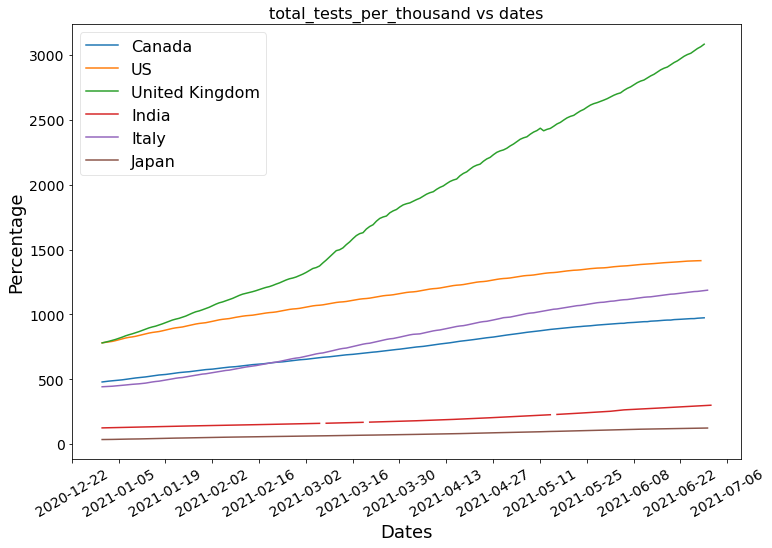

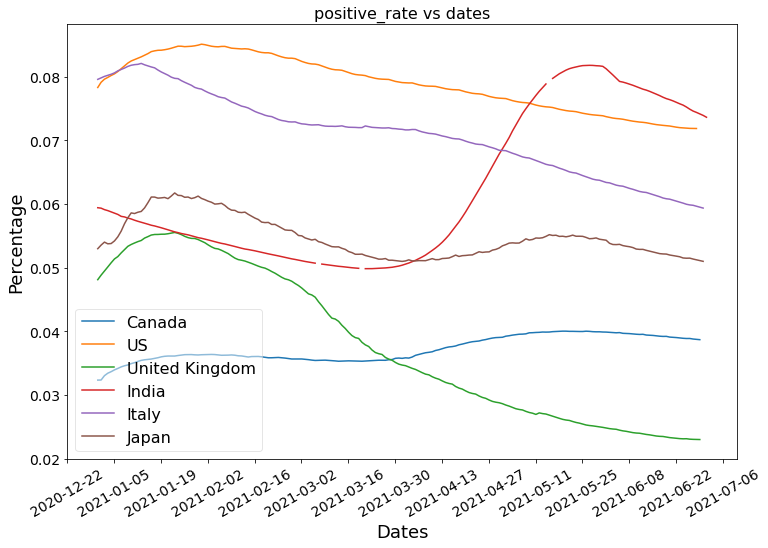

In [25]:
def plot_rates(target_countries, df, label, title):
    fig = plt.figure(facecolor='w', figsize=(12, 8))
    ax = fig.add_subplot(111)
    for c in target_countries:
        rate = df[df['location'] == c][label].to_list()
        date = df[df['location'] == c]['date']
        ax.plot(date, rate, label=c)
    ax.set_xlabel('Dates')
    ax.set_ylabel('Percentage')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 14))
    ax.xaxis.set_tick_params(rotation=30)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    plt.title(title)

target_countries = ['Canada', 'US', 'United Kingdom', 'India', 'Italy', 'Japan']
plot_rates(target_countries, df, "total_tests_per_thousand", "total_tests_per_thousand vs dates")
plot_rates(target_countries, df, "positive_rate", "positive_rate vs dates")

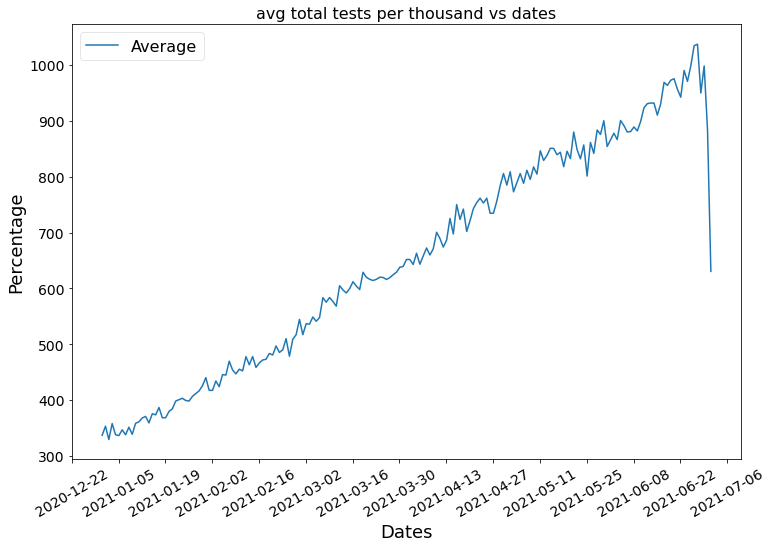

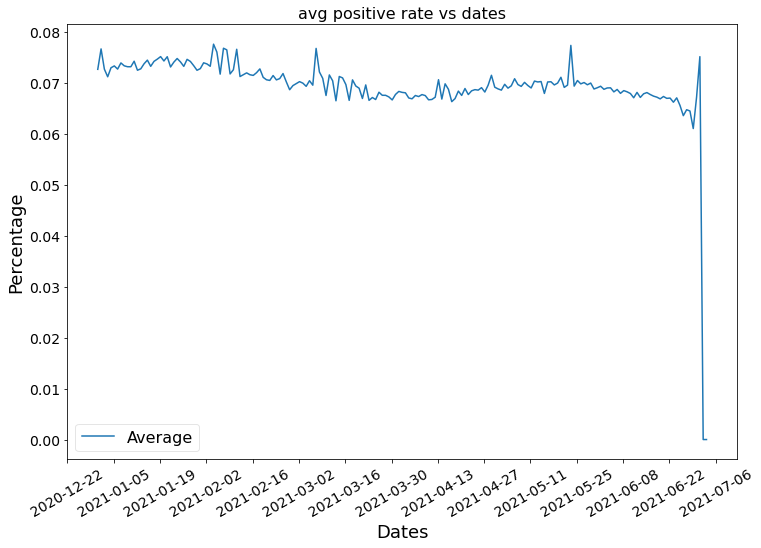

In [26]:
plot_rates(['Average'], df, "total_tests_per_thousand", "avg total tests per thousand vs dates")
plot_rates(['Average'], df, "positive_rate", "avg positive rate vs dates")

In [27]:
df.to_csv('datasets/test-rate-processed.csv', index=False, columns=["location", "date", "positive_rate"], header=False)